<h2>Importing Libraries and Loading Datasets</h2>

In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install xgboost

In [49]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_csv("Food_Delivery_Times.csv")

In [6]:
df.sample(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
210,66,11.08,Snowy,Medium,Morning,Bike,9,0.0,57
816,945,4.53,Snowy,Medium,Morning,Scooter,18,4.0,49
150,644,6.89,Rainy,Medium,Afternoon,Bike,11,6.0,43
21,175,13.08,Rainy,Low,Morning,Car,16,4.0,58
784,385,14.83,Rainy,Low,Morning,Car,19,4.0,126


<h2>Data Wrangling</h2>

In [7]:
df.columns

Index(['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [9]:
df.shape

(1000, 9)

In [10]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [11]:
df.describe(include="object")

,Weather,Traffic_Level,Time_of_Day,Vehicle_Type
count,970,970,970,1000
unique,5,3,4,3
top,Clear,Medium,Morning,Bike
freq,470,390,308,503


In [12]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [13]:
df.corr(numeric_only=True)

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
Order_ID,1.000000,-0.024483,-0.035100,0.013152,-0.036650
Distance_km,-0.024483,1.000000,-0.009037,-0.007842,0.780998
Preparation_Time_min,-0.035100,-0.009037,1.000000,-0.030830,0.307350
Courier_Experience_yrs,0.013152,-0.007842,-0.030830,1.000000,-0.090433
Delivery_Time_min,-0.036650,0.780998,0.307350,-0.090433,1.000000


<h4> Order ID and courier experience seem to have very little effect on the delivery time, on the other hand, preparation time plays a role in estimation of delivery time and distance has very high correlation with delivery time.</h4>

In [14]:
df.duplicated().sum()#There are no duplicated rows in the dataset

0

<h2>Exploratory Data Analysis</h2>

In [15]:
df_eda=df.copy()#Creating a duplicate for the dataframe to temporarily fill out the missing values and then perform EDA

In [16]:
df_eda.drop('Order_ID',axis=1,inplace=True)

In [17]:
df_eda.columns

Index(['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

In [18]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    df_eda[col].fillna(df_eda[col].mode()[0], inplace=True)
    
df_eda['Courier_Experience_yrs'].fillna(df_eda['Courier_Experience_yrs'].median(), inplace=True)

In [19]:
df_eda.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [20]:
num_cols=['Distance_km','Preparation_Time_min','Courier_Experience_yrs','Delivery_Time_min']

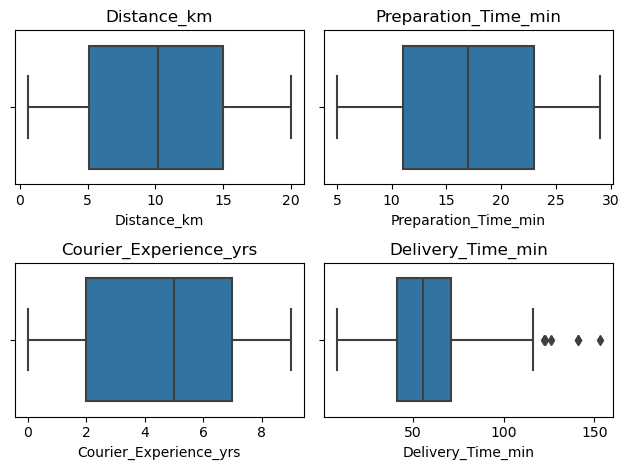

In [21]:
for i,col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=df_eda,x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

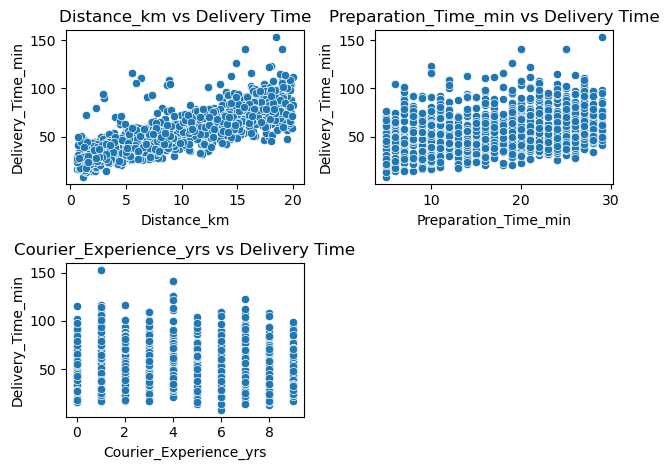

In [22]:
for i,col in enumerate(['Distance_km','Preparation_Time_min','Courier_Experience_yrs']):
    plt.subplot(2,2,i+1)
    sns.scatterplot(data=df_eda,x=col,y='Delivery_Time_min')
    plt.title(f"{col} vs Delivery Time")
plt.tight_layout()
plt.show()

In [23]:
cat_cols_eda=[col for col in df_eda.columns if df[col].dtype=='object']
cat_cols_eda

['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

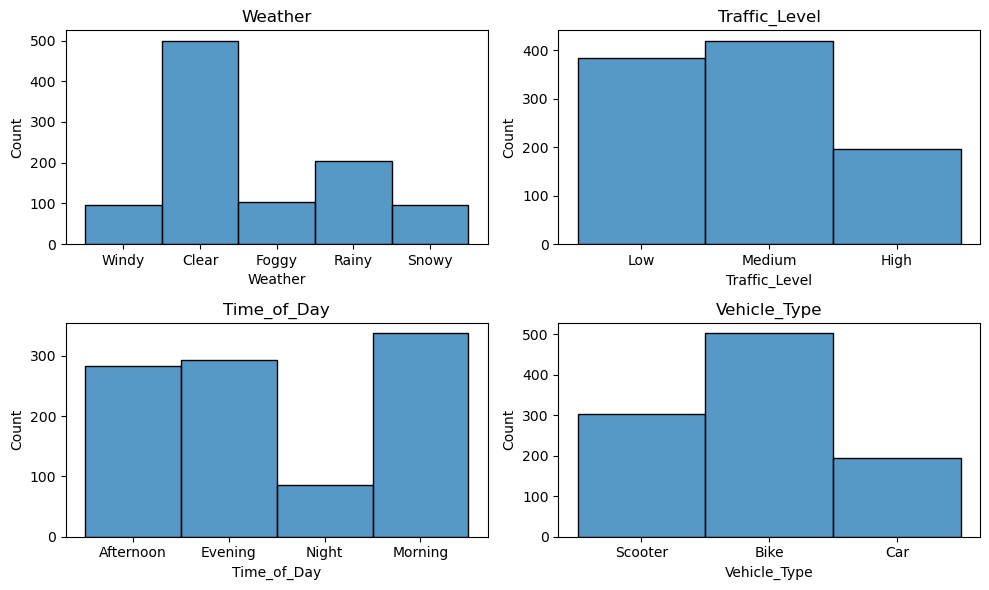

In [24]:
plt.figure(figsize=(10,6))
for i,col in enumerate(cat_cols_eda):
    plt.subplot(2,2,i+1)
    sns.histplot(data=df_eda,x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

In [25]:
for col in cat_cols_eda:
    le=LabelEncoder()
    df_eda[col]=le.fit_transform(df_eda[col])

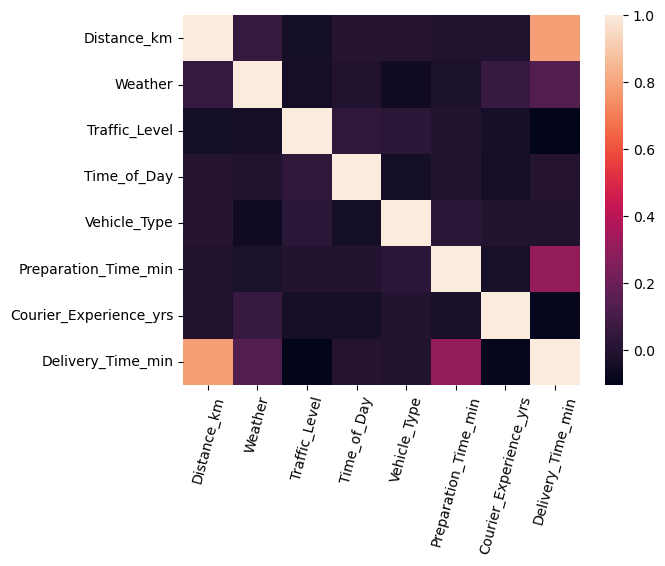

In [26]:
sns.heatmap(df_eda.corr())
plt.xticks(rotation=75)
plt.show()

<h4>The distance has the highest effect on the delivery time followed by preparation time.<br>
Weather, Time of Day, Vehicle Type have little effect on the delivery time.<br>
Courier experience, Traffic Level, Order ID have almost no effect on the delivery time.</h4>

<h2>Feature Engineering & Model Training</h2>

In [27]:
df.drop("Order_ID",axis=1,inplace=True)#Order ID doesnot contribute in estimating the delivery time

In [28]:
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [29]:
X=df.drop('Delivery_Time_min',axis=1)
y=df['Delivery_Time_min']

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
num_cols=['Distance_km','Preparation_Time_min','Courier_Experience_yrs']

In [32]:
cat_cols=[col for col in df_eda.columns if df[col].dtype=='object']
cat_cols

['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

In [33]:
num_transformer=Pipeline(steps=[('Imputer',SimpleImputer()),('Scaler',StandardScaler())])
col_transformer=Pipeline(steps=[('Imputer',SimpleImputer(strategy='most_frequent')),('Encoder',OneHotEncoder())])

In [34]:
preprocessor=ColumnTransformer(transformers=[('numerical_columns',num_transformer,num_cols),
                                              ('categorical_columns',col_transformer,cat_cols)])

In [35]:
def objective(trial):
    model_name = trial.suggest_categorical("model", ["xgb", "linear", "dt", "rf", "svr"])

    if model_name=="xgb":
        model=XGBRegressor(
            n_estimators=trial.suggest_int('n_estimators',50,200),
            max_depth=trial.suggest_int("max_depth",3,10),
            learning_rate=trial.suggest_float("learning_rate",0.01,0.3),
            random_state=42)

    elif model_name=="linear":
        model=LinearRegression()

    elif model_name=="dt":
        model=DecisionTreeRegressor(
            max_depth=trial.suggest_int('max_depth', 3, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            random_state=42)

    elif model_name=="rf":
        model=RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            random_state=42
        )

    elif model_name=="svr":
        model=SVR(
             C=trial.suggest_float('C', 0.1, 100.0, log=True),
            epsilon=trial.suggest_float('epsilon', 0.01, 1.0),
            kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        )

    pipeline=Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('regressor',model)])

    score = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)#5 fold CV
    return -1 * score.mean()

In [36]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-07 19:23:21,171] A new study created in memory with name: no-name-aa0bde41-7f5b-472a-ac14-5840bbb80e90
[I 2025-07-07 19:23:21,360] Trial 0 finished with value: 13.906783602875965 and parameters: {'model': 'dt', 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 13.906783602875965.
[I 2025-07-07 19:23:22,584] Trial 1 finished with value: 11.942319165846872 and parameters: {'model': 'xgb', 'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.12437305500081301}. Best is trial 1 with value: 11.942319165846872.
[I 2025-07-07 19:23:22,794] Trial 2 finished with value: 11.03705033263077 and parameters: {'model': 'linear'}. Best is trial 2 with value: 11.03705033263077.
[I 2025-07-07 19:23:22,982] Trial 3 finished with value: 15.541030827748253 and parameters: {'model': 'dt', 'max_depth': 17, 'min_samples_split': 6}. Best is trial 2 with value: 11.03705033263077.
[I 2025-07-07 19:23:28,199] Trial 4 finished with value: 13.108743994180164 and parameters: {'model':

In [37]:
best_params=study.best_params
best_model_name=best_params.pop("model")

In [38]:
if best_model_name == "xgb":
    best_model = XGBRegressor(**best_params, random_state=42)
elif best_model_name == "linear":
    best_model = LinearRegression()
elif best_model_name == "dt":
    best_model = DecisionTreeRegressor(**best_params, random_state=42)
elif best_model_name == "rf":
    best_model = RandomForestRegressor(**best_params, random_state=42)
elif best_model_name == "svr":
    best_model = SVR(**best_params)

In [39]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

In [40]:
final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_columns',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['Distance_km',
                                                   'Preparation_Time_min',
                                                   'Courier_Experience_yrs']),
                                                 ('categorical_columns',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder())]),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day',
                                                   'Vehicle_Type'])])),
                ('regressor', LinearRegression())])

In [41]:
y_pred = final_pipeline.predict(X_test)

<h2>Evaluation Metrics</h2>

In [48]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Best Model:", best_model_name)
print("RMSE:", rmse)

Best Model: linear
RMSE: 8.949455247557282


In [44]:
rmse / y.mean()

0.15774968708237472

In [47]:
r2 = r2_score(y_test, y_pred)
print("R2 Score:",r2)

R2 Score: 0.8213120724650038


In [50]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:",mae)

Mean Absolute Error: 6.06374772879796


<h2>Saving the trained model</h2>

In [51]:
import joblib
joblib.dump(final_pipeline, "food_delivery_model.pkl")

['food_delivery_model.pkl']

### Observations:
- The model explains **82.13%** of the variance in delivery time, which indicates a **very good fit**.
- The **average prediction error** is approximately **9 minutes**, which is only about **15% of the average delivery time*
- The **average absolute prediction error is ~6 minutes**, which is quite reasonable for real-world use.*.
- These results indicate that the model can **predict food delivery times reliably**, though slight improvements might still be possible by:
  - Collecting more data
  - Including more feation)tion)